# <ins>DATA 401 Project 3 Code</ins>

**This is the code used for Project 3 for Group 6 (Flo Costa, Anish Yakkala, and Zachary Gelber). Comments and text blocks have been added to most of the code below to explain their use and function. Please consult the accompanying README file for how to run different sections of the code.**

## <ins>Dataset Creation and Feature Engineering</ins>

### ***In this section we split the data into a training, validation, and testing set, fill in missing values using a modified K-Nearest Neighbors algorithm, and use forward stepwise regression to determine our most informative variables from the data.***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rand

import math

**Here we import the needed packages to build and evaluate our linear regresion model and neural network.**

In [2]:
%cd sberbank-russian-housing-market
%cd sberbank-russian-housing-market

C:\Users\speed\Documents\Senior Year (2020-2021)\Fall Quarter\Data 401\Project 3\sberbank-russian-housing-market
C:\Users\speed\Documents\Senior Year (2020-2021)\Fall Quarter\Data 401\Project 3\sberbank-russian-housing-market\sberbank-russian-housing-market


**Here we move into the directory containing the necessary data files.**

In [3]:
df = pd.read_csv('train.csv')
macro = pd.read_csv('macro.csv')

df_merge = df.merge(right = macro, how = "left", on = "timestamp")
df_merge.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


**Here we read in our two main data files: "train.csv" and "macro.csv". The former contains specific information about the property and the surrounding area, while the latter contains macroeconomic information for dates from August 20th, 2011 to XXXXXXXXXX, 2016. Since "train.csv" also has a variable for date of transaction, we perform a join the two data sets by date. Notice that even in the few listings seen above, many missing values can be seen.**

In [4]:
to_toss_na = ["provision_retail_space_modern_sqm", 
             "provision_retail_space_sqm", 
             "students_reg_sports_share",
             "museum_visitis_per_100_cap",
             "theaters_viewers_per_1000_cap",
             "load_of_teachers_preschool_per_teacher",
             "hospital_beds_raion"]    #Thrown out because too many NaN values.

to_toss_geo = ["sub_area",
              "ID_railroad_station_walk",
              "ID_railroad_station_avto",
              "ID_big_road1",
              "ID_big_road2",
              "ID_railroad_terminal",
              "ID_bus_terminal"]       #Thrown out because they are categorical variables 
                                       #for geographic locations, which are not allowed to 
                                       #be dummified.

to_toss_ind = ["culture_objects_top_25",
              "thermal_power_plant_raion",
              "incineration_raion",
              "oil_chemistry_raion",
              "railroad_terminal_raion",
              "big_market_raion",
              "nuclear_reactor_raion",
              "detention_facility_raion",
              "water_1line",
              "big_road1_1line",
              "railroad_1line",
              "radiation_raion"]     #Thrown out as they are redundant indicator variables. For
                                     #each of these there exists a more detailed numeric version.

to_toss_weird = ["child_on_acc_pre_school",
                "modern_education_share",
                "old_education_build_share"]     #Thrown out because they contain weird values.
                                                 #Should discuss if they are worth keeping.

to_dummify = ["product_type",
             "ecology",
             "material",
             "state"]      #These are the variables that need to be dummified.

**Not every variable in this data set is useful. Although our goal is for the neural networks to parse out relevant information to predict housing prices, we can aid this process by pre-emptively removing variables that we believe will not contribute to the model. By manually going through each variable, we can make decisions about whether or not to consider it in our models.**

**First, we threw out variables that had too many missing values. Although we will later try to fill in these missings values using K-Nearest Neighbors, this becomes more difficult if most of the data is already missing. Furthermore, it is questionable how useful a variable can be if most the data is not even there. For example, the variable "provision_retail_space_modern_sqm" was missing over 95% of its values. Next, we threw out variables regarding geographic information, as these were forbidden by the project specifications. Then, we tossed out variables we believed were redundant. For example, "thermal_power_plant_raion" is a "yes/no" variable that indicates if a property is near a thermal power plant. However, there also exists a variable called "thermal_power_plant_km" that indicates the distance in kilometers from a property to the nearest thermal power plant. Since these variables describe nearly the same thing, we felt it made little sense to keep both, so we tossed the former. Finally, we also tossed variables that had some strange values.**

**We also created a list of categorical variables that would need to be dummified later.**

In [5]:
test_and_val_size = int(len(df_merge)*0.2)
test_and_val_idx = rand.sample(list(range(len(df_merge))),test_and_val_size)

val_idx = rand.sample(test_and_val_idx,int(test_and_val_size/2))
test_idx = list(set(test_and_val_idx) - set(val_idx))

**Here we set the indexes for the validation and testing set, leaving the rest for the training set. We chose to do an 80%/10%/10% split for the training, validation, and testing respectively.**

In [6]:
df_train = df_merge.loc[~df_merge.index.isin(test_and_val_idx)]
y_train = df_train["price_doc"]
df_train = df_train.drop(to_toss_na + to_toss_geo + to_toss_ind + to_toss_weird + ["timestamp","id","price_doc"], axis=1)
df_train = pd.get_dummies(df_train, columns = to_dummify)
df_train.loc[df_train["build_year"] < 1500, "build_year"] = np.nan

false_dummies = ["raion_build_count_with_material_info", "students_state_oneshift"]

for dummy in to_dummify:
    dummy_col_list = [col for col in df_train.columns if dummy + "_" in col and col not in false_dummies]
    mask = df_train[dummy_col_list].sum(axis=1) == 0
    df_train.loc[mask,dummy_col_list] = float('NaN')

df_train.head()

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,state_1.0,state_2.0,state_3.0,state_4.0,state_33.0
0,43,27.0,4.0,NaN,NaN,NaN,NaN,6.407578e+06,155572,0.189727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,43,29.0,2.0,NaN,NaN,NaN,NaN,4.808270e+06,101708,0.112560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,77,77.0,4.0,NaN,NaN,NaN,NaN,8.398461e+06,108171,0.015234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,67,46.0,14.0,NaN,NaN,NaN,NaN,7.506452e+06,43795,0.007670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,25,14.0,10.0,NaN,NaN,NaN,NaN,1.032047e+07,57405,0.523439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Here we create our training set based on the indexes randomized above. After dropping the problematic variables discussed earlier, we dummify the categorical variables we also listed. Additionally, we also set any listings with a build year of less than 1500 to NaN. This is because some listings of build years of 0 or 1, which we believed to indicate missing values.**

In [7]:
df_val = df_merge.loc[val_idx]
y_val = df_val["price_doc"]
df_val = df_val.drop(to_toss_na + to_toss_geo + to_toss_ind + to_toss_weird + ["timestamp","id","price_doc"], axis=1)
df_val = pd.get_dummies(df_val, columns = to_dummify)
df_val.loc[df_val["build_year"] < 1500, "build_year"] = np.nan

false_dummies = ["raion_build_count_with_material_info", "students_state_oneshift"]

for dummy in to_dummify:
    dummy_col_list = [col for col in df_val.columns if dummy + "_" in col and col not in false_dummies]
    mask = df_val[dummy_col_list].sum(axis=1) == 0
    df_val.loc[mask,dummy_col_list] = float('NaN')

df_val.head()

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,ecology_satisfactory,material_1.0,material_2.0,material_4.0,material_5.0,material_6.0,state_1.0,state_2.0,state_3.0,state_4.0
228,42,19.0,9.0,NaN,NaN,NaN,NaN,2.615514e+07,178264,0.137846,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2611,58,43.0,6.0,NaN,NaN,NaN,NaN,7.462270e+06,129207,0.387100,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14679,77,39.0,16.0,18.0,2004.0,2.0,17.0,7.792845e+06,21155,0.528252,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
14667,35,34.0,8.0,9.0,1972.0,1.0,7.0,1.428699e+07,157010,0.389354,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4718,73,42.0,13.0,NaN,NaN,NaN,NaN,5.333221e+06,64931,0.074077,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Here we repeat exactly what we did for the training set, only this time for the validation set.**

In [8]:
df_test = df_merge.loc[test_idx]
y_test = df_test["price_doc"]
df_test = df_test.drop(to_toss_na + to_toss_geo + to_toss_ind + to_toss_weird + ["timestamp","id","price_doc"], axis=1)
df_test = pd.get_dummies(df_test, columns = to_dummify)
df_test.loc[df_test["build_year"] < 1500, "build_year"] = np.nan

false_dummies = ["raion_build_count_with_material_info", "students_state_oneshift"]

for dummy in to_dummify:
    dummy_col_list = [col for col in df_test.columns if dummy + "_" in col and col not in false_dummies]
    mask = df_test[dummy_col_list].sum(axis=1) == 0
    df_test.loc[mask,dummy_col_list] = float('NaN')

df_test.head()

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,ecology_satisfactory,material_1.0,material_2.0,material_4.0,material_5.0,material_6.0,state_1.0,state_2.0,state_3.0,state_4.0
16385,41,26.0,1.0,5.0,1962.0,2.0,5.0,1.250576e+07,61396,0.403651,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,89,50.0,9.0,NaN,NaN,NaN,NaN,1.258354e+07,178473,0.194703,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,42,27.0,5.0,NaN,NaN,NaN,NaN,4.787424e+06,96959,0.038456,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24584,38,18.0,16.0,16.0,1973.0,1.0,9.0,3.292112e+06,73148,0.063747,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
24587,42,NaN,14.0,18.0,NaN,1.0,1.0,1.084231e+07,85219,0.062172,...,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


**Again we repeat what we did for the training and validation set, only this time on the testing set.**

In [9]:
bad_dummies = ["state_33.0", "material_3.0", "ecology_no data"]
df_train.drop(bad_dummies, axis=1, inplace=True, errors='ignore')
df_val.drop(bad_dummies, axis=1, inplace=True, errors='ignore')
df_test.drop(bad_dummies, axis=1, inplace=True, errors='ignore')

**Some of the categories in our categorical variables are outliers or mistakes. The category "state_33.0" and "material_3.0", for example, have only one listing in the entire data set. Thus we think they are either mistakes or incredibly rare. Either way, we do not think they are worth keeping. The category "ecology_no data" is obviously a version of a missing variable, so we simply drop it.**

In [10]:
na_sum = df_train.isna().sum()
no_nan_cols = na_sum[na_sum == 0].index
df_knn = df_train[no_nan_cols]
knn_mean = df_knn.mean()
knn_std = df_knn.std()
df_knn = (df_knn - knn_mean)/(knn_std)
df_knn.head()

,full_sq,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,...,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,apartment_fund_sqm,product_type_Investment,product_type_OwnerOccupier,ecology_excellent,ecology_good,ecology_poor,ecology_satisfactory
0,-0.276134,-0.547093,1.235106,-0.167852,-0.999331,1.161374,0.312110,1.240210,0.085088,-0.32857,...,-3.254393,1.060682,-1.755026,0.256394,0.752342,-0.752342,-0.385354,1.800638,-0.597033,-0.371398
2,-0.276134,-0.624829,0.303941,-0.609123,-0.000820,0.192293,-0.021983,0.211982,0.665366,-0.32857,...,-3.254393,1.060682,-1.755026,0.256394,0.752342,-0.752342,-0.385354,-0.555336,1.674880,-0.371398
4,0.559859,-0.450324,0.415669,-1.165666,-0.685397,0.146946,0.980298,0.347592,1.245643,-0.32857,...,-3.254393,1.060682,-1.755026,0.256394,0.752342,-0.752342,2.594907,-0.555336,-0.597033,-0.371398
5,0.313979,-0.493681,-0.697222,-1.208917,3.098435,-0.714925,-0.690171,-0.713723,-0.495189,-0.32857,...,-3.254393,1.060682,-1.755026,0.256394,0.752342,-0.752342,-0.385354,-0.555336,1.674880,-0.371398
6,-0.718718,-0.356902,-0.461941,1.740428,-0.643331,-0.704178,0.312110,-0.639526,0.085088,-0.32857,...,-3.254393,1.060682,-1.755026,0.256394,0.752342,-0.752342,-0.385354,-0.555336,1.674880,-0.371398


**Our goal is to use K-Nearest Neighbors to try and fill in the missing values. To determine the neighbors of a particular listing, we use the data frame created above, "df_knn". This data frame contains only variables that have no missing values, as well as standardized versions of each value. Thus we can use that to determine the closest neighbors of any particular listing by calculating the Euclidean distance.**

In [ ]:
k = 5            

for i in df_train.index:
  curr_row = df_train.loc[i]
  if curr_row.isna().sum() > 0:
    curr_nan_cols = curr_row[curr_row.isna()].index
    curr_row_knn = df_knn.loc[i]
    nearest = df_knn.subtract(curr_row_knn,axis=1).pow(2).sum(axis=1).sort_values().index
    curr_nan_cols_dict = {col: [] for col in curr_nan_cols}
    k_limit = k*len(curr_nan_cols)
    for j in nearest:
      if j != i:
        for col in curr_nan_cols:
          if len(curr_nan_cols_dict[col]) < k:
            curr_cell = df_train.loc[j][col]
            if not np.isnan(curr_cell):
              curr_nan_cols_dict[col].append(curr_cell)
              k_limit -= 1
      if k_limit == 0:
        for key in curr_nan_cols_dict.keys():
          df_train.loc[i,key] = pd.Series(curr_nan_cols_dict[key]).mean()
        break

**Here we implement our K-Nearest Neighbors algorithm. First, we iterate through each element of "df_train". If it does not contain any missing values, we move on. Otherwise, we use "df_knn" to create a sorted list of its closet neighbors. We also create a dictionary for each missing value of the current listing. We then iterate through this list, adding values from the neighbors to the corresponding list of the dictionary if it is not missing. We repeat this until each list in the dictionary has k elements (for our project we chose k = 5). Then we take the mean of that list and use it to fill in the missing value. We then repeat this process for the next element of "df_train" until we are done.**

In [ ]:
df_train.to_csv("df_train_vfinal")   #Used to save output

**The above process can take a few hours to complete, so we save the output to save time.**

In [11]:
df_train = pd.read_csv("df_train_vfinal",index_col = "Unnamed: 0")
df_train.head()

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,ecology_satisfactory,material_1.0,material_2.0,material_4.0,material_5.0,material_6.0,state_1.0,state_2.0,state_3.0,state_4.0
0,43,27.0,4.0,10.600,1974.200,2.400,6.600,6.407578e+06,155572,0.189727,...,0.0,0.800,0.0,0.0,0.200,0.0,0.0,0.400,0.600,0.0
1,34,19.0,3.0,12.720,1972.840,1.880,7.120,9.589337e+06,115352,0.372602,...,0.0,0.760,0.0,0.0,0.240,0.0,0.0,0.280,0.720,0.0
2,43,29.0,2.0,8.464,1967.808,2.256,5.944,4.808270e+06,101708,0.112560,...,0.0,0.512,0.4,0.0,0.088,0.0,0.0,0.736,0.264,0.0
3,89,50.0,9.0,14.664,1987.408,2.256,8.544,1.258354e+07,178473,0.194703,...,0.0,0.912,0.0,0.0,0.088,0.0,0.0,0.136,0.864,0.0
4,77,77.0,4.0,4.200,1940.200,3.000,5.200,8.398461e+06,108171,0.015234,...,0.0,0.200,0.8,0.0,0.000,0.0,0.2,0.400,0.400,0.0


**Here we read in our output from before for "df_train".**

In [ ]:
k = 5
counter = 0

for i in df_val.index:
  curr_row = df_val.loc[i]
  if curr_row.isna().sum() > 0:
    curr_nan_cols = curr_row[curr_row.isna()].index
    curr_row_knn = (df_val.loc[i] - knn_mean)/knn_std
    nearest = df_knn.subtract(curr_row_knn,axis=1).pow(2).sum(axis=1).sort_values().index
    curr_nan_cols_dict = {col: [] for col in curr_nan_cols}
    k_limit = k*len(curr_nan_cols)
    for j in nearest:
      if j != i:
        for col in curr_nan_cols:
          if len(curr_nan_cols_dict[col]) < k:
            curr_cell = df_train.loc[j][col]
            if not np.isnan(curr_cell):
              curr_nan_cols_dict[col].append(curr_cell)
              k_limit -= 1
      if k_limit == 0:
        for key in curr_nan_cols_dict.keys():
          df_val.loc[i,key] = pd.Series(curr_nan_cols_dict[key]).mean()
        break

**Here we repeat a similar process as we did for "df_train", only this time we are filling in values for "df_val". Notably, we are using the "df_knn" that was created from "df_train" to find the closest neighbors; it doesn't make too much sense to use the validation to fill in values for the validation set.**

In [ ]:
df_val.to_csv("df_val_vfinal")   #Used to save output

**Again we save our output to save time.**

In [12]:
df_val = pd.read_csv("df_val_vfinal",index_col = "Unnamed: 0")
df_val.head()

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,ecology_satisfactory,material_1.0,material_2.0,material_4.0,material_5.0,material_6.0,state_1.0,state_2.0,state_3.0,state_4.0
25422,52,25.480000,15.0,17.0,1977.560000,2.0,0.0,8.097032e+06,31167,0.109135,...,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.480000,0.520000,0.0
14917,88,44.000000,11.0,24.0,1998.000000,2.0,11.0,7.984444e+06,142243,0.372735,...,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0
11757,42,41.353313,3.0,0.0,2003.621928,1.0,0.0,1.186638e+08,7538,0.551883,...,0.0,1.0,0.0,0.0,0.0,0.0,0.939554,0.020821,0.039625,0.0
21055,34,19.000000,1.0,9.0,1971.000000,1.0,6.0,3.799999e+06,76308,0.232656,...,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0
13124,60,29.631892,13.0,17.0,2013.304000,2.0,1.0,7.307411e+06,75377,0.065444,...,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0


**Here we read in our output from before for "df_val".**

In [ ]:
k = 5
counter = 0

for i in df_test.index:
  counter += 1
  if counter % 50 == 0:
    print(counter)
  curr_row = df_test.loc[i]
  if curr_row.isna().sum() > 0:
    curr_nan_cols = curr_row[curr_row.isna()].index
    curr_row_knn = (df_test.loc[i] - knn_mean)/knn_std
    nearest = df_knn.subtract(curr_row_knn,axis=1).pow(2).sum(axis=1).sort_values().index
    curr_nan_cols_dict = {col: [] for col in curr_nan_cols}
    k_limit = k*len(curr_nan_cols)
    for j in nearest:
      if j != i:
        for col in curr_nan_cols:
          if len(curr_nan_cols_dict[col]) < k:
            curr_cell = df_train.loc[j][col]
            if not np.isnan(curr_cell):
              curr_nan_cols_dict[col].append(curr_cell)
              k_limit -= 1
      if k_limit == 0:
        for key in curr_nan_cols_dict.keys():
          df_test.loc[i,key] = pd.Series(curr_nan_cols_dict[key]).mean()
        break

**Again we repeat our process for filling in missing values, only this time for "df_test".**

In [ ]:
df_test.to_csv("df_test_vfinal")   #Used to save output

**Again we save our output to save time.**

In [13]:
df_test = pd.read_csv("df_test_vfinal",index_col = "Unnamed: 0")
df_test.head()

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,...,ecology_satisfactory,material_1.0,material_2.0,material_4.0,material_5.0,material_6.0,state_1.0,state_2.0,state_3.0,state_4.0
8193,32,16.0,4.0,9.324134,1977.701274,1.718861,5.042330,6.206099e+06,111874,0.128123,...,0.0,0.728819,0.000000,0.000000,0.271181,0.0,0.083632,0.707033,0.209332,0.000004
24584,38,18.0,16.0,16.000000,1973.000000,1.000000,9.000000,3.292112e+06,73148,0.063747,...,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
11,38,19.0,11.0,11.068073,1973.690888,2.213239,6.813686,7.632940e+06,78810,0.051844,...,1.0,0.719500,0.128544,0.000000,0.151956,0.0,0.000000,0.391329,0.608671,0.000000
13,31,31.0,4.0,6.745540,1963.437324,1.681712,6.049854,1.163805e+07,123280,0.068202,...,0.0,0.138487,0.477781,0.000699,0.383034,0.0,0.000000,0.794906,0.205023,0.000071
18,59,33.0,10.0,10.870405,1972.835403,2.200227,6.715337,1.488362e+07,72131,0.024444,...,0.0,0.703830,0.144197,0.000000,0.151974,0.0,0.000000,0.413688,0.586312,0.000000


**Here we read in our output from before for "df_test".**

In [ ]:
y_train.to_csv("y_train_vfinal")
y_val.to_csv("y_val_vfinal")
y_test.to_csv("y_test_vfinal")

**We also save our output for the response variable.**

In [14]:
y_train = pd.read_csv("y_train_vfinal",index_col = "Unnamed: 0")
y_val = pd.read_csv("y_val_vfinal",index_col = "Unnamed: 0")
y_test = pd.read_csv("y_test_vfinal",index_col = "Unnamed: 0")

**Here we read in our response variables.**

In [15]:
def solve_for_B(x, y, n):
    # takes a data frame, and a numpy array
    x = np.concatenate((np.ones((n,1)), x.to_numpy()), axis=1)
    x_transpose = np.transpose(x)
    return np.linalg.solve(np.matmul(x_transpose, x), x_transpose @ y)

def get_predicted_values(beta, design_matrix, n):
    return np.matmul(np.concatenate((np.ones((n,1)), design_matrix), axis = 1), beta)

def BIC(predictions, actuals, d, n):
    # numpy array - predictions, numpy array - actual 
    return (np.square(actuals - predictions).sum()) + (d * np.log(n))

def RSquaredAdj(predictions, actuals, d, n):
    x1 = np.square(actuals - actuals.mean()).sum()
    x2 = np.square(predictions - actuals.mean()).sum()
    r2 = x2/x1
    return (1 - ((1 - r2) * (n - 1) / (n - d - 1)))

def RMSE(predictions, actuals, n):
    return np.sqrt((np.square(actuals - predictions).sum()) / n) 

def train_model(design_matrix, dependent_variable_series):
    n = design_matrix.shape[0]
    beta = solve_for_B(design_matrix, dependent_variable_series, n)
    predicted_values = get_predicted_values(beta, design_matrix, n)
    calculated_BIC = BIC(predicted_values, dependent_variable_series, d = design_matrix.shape[1], n = n)
    calculated_RMSE = RMSE(predicted_values, dependent_variable_series, n = n)
    residuals = predicted_values - dependent_variable_series
    return beta, calculated_BIC, calculated_RMSE, residuals

**Here are the functions used to train our linear regression model.**

In [16]:
def train_crossv_model(df, y): 
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(.25 * m)
    train_1 = df.iloc[perm[:train_end]]
    test_1 = y.iloc[perm[:train_end]]

    train_2 = df.iloc[perm[train_end:train_end*2]]
    test_2 = y.iloc[perm[train_end:train_end*2]]

    train_3 = df.iloc[perm[train_end*2:train_end*3]]
    test_3 = y.iloc[perm[train_end*2:train_end*3]]

    train_4 = df.iloc[perm[train_end*3:]]
    test_4 = y.iloc[perm[train_end*3:]]
    return train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4


def get_average_RMSE_for_one_model(df, y):
    train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4 = train_crossv_model(df, y)

    beta4, bic4, RMSE4, _ = train_model(train_1.append([train_2, train_3]), test_1.append([test_2, test_3]))

    beta2, bic3,RMSE2, _ = train_model(train_1.append([train_4, train_3]), test_1.append([test_4, test_3]))

    beta3, bic2, RMSE3, _ = train_model(train_1.append([train_2, train_4]), test_1.append([test_2, test_4]))

    beta1, bic1, RMSE1, _ = train_model(train_4.append([train_2, train_3]), test_4.append([test_2, test_3]))

    return sum([RMSE1, RMSE2, RMSE3, RMSE4]) / 4, sum([bic1, bic2, bic3, bic4]) / 4

**Here is the code for our cross-validation.**

In [ ]:
# forward cross validated stepwise

train_data = df_train.copy()
train_data.reset_index(drop=True,inplace=True)
y_temp = y_train.copy()
y_temp.reset_index(drop=True,inplace=True)
df_with_col = pd.DataFrame()

col_added = []
rmses = []

for i in range(0,50):

    min_col = None
    min_RMSE = 100000000000000000000
    min_bic = 10000000000000000000

    for col in train_data.columns:

        df_with_col[col] = train_data[col]
        
        try:
          new_RMSE, new_bic = get_average_RMSE_for_one_model(df_with_col, y_temp)
                
          if new_RMSE[0] <= min_RMSE:
            min_bic = new_bic
            min_RMSE = new_RMSE
            min_col = col
        except:
          pass
            
        df_with_col.drop(columns=[col], inplace=True)

    if min_col is not None:
        print(min_col)
        df_with_col[min_col] = train_data[min_col]
        train_data.drop(columns=[min_col], inplace=True)
        rmses.append(min_RMSE)
        print("bic: " + str(min_bic))
        print("rmse: " + str(min_RMSE))
        col_added.append(min_col)
        print("")
    else:
        print("Failed #2")

**This is our code for the forward stepwise regression. We use it to find the top 50 variables that we believe minimie the RMSE.**

In [ ]:
t_cols = df.columns
m_cols = macro.columns
t_c = 0
m_c = 0
for col in col_added:
    if col in t_cols:
        t_c += 1
    elif col in m_cols:
        m_c += 1
    else:
        print(col)
print("t: " + str(t_c) + " | m: " + str(m_c))

**In order to abide by the projects specifications, we cannot use more than 10 variables from the "macro.csv" file. Here we count each of the variables found in the stepwise regression to see which ones came from "train.csv" and which ones came from "macro.csv". We ended up having all 50 of our variables coming from "train.csv".**

In [ ]:
for i in range(1,len(col_added)):
    print(i)
    col_added_mod = col_added[:-i]
    df_train_final = df_train[col_added_mod]
    df_val_final = df_val[col_added_mod]
    df_test_final = df_test[col_added_mod]
    df_train_final_norm = (df_train_final-df_train_final.mean())/df_train_final.std()
    y_train_final_norm = (y_train_final-y_train_final.mean())/y_train_final.std()

    df_val_final_norm = (df_val_final-df_val_final.mean())/df_val_final.std()
    y_val_final_norm = (y_val_final-y_val_final.mean())/y_val_final.std()

    df_test_final_norm = (df_test_final-df_test_final.mean())/df_test_final.std()
    y_test_final_norm = (y_test_final-y_test_final.mean())/y_test_final.std()
    
    betas = linearRegression(df_train_final_norm,y_train_final_norm)
    print(np.square(df_train_final_norm.dot(betas).to_numpy() - y_train_final_norm.to_numpy()).mean())
    print(np.square(df_val_final_norm.dot(betas).to_numpy() - y_val_final_norm.to_numpy()).mean())
    print(np.square(df_test_final_norm.dot(betas).to_numpy() - y_test_final_norm.to_numpy()).mean())
    print("\n")

**Of our 50 variables, we wanted to further dive deeper to find out if all of them are actually predictive. To do so, we would the training, validation, and testing MSE using the top 50 variables, then the top 49, and so on until we iterated through the whole list. Then, rather than picking the one that had the lowest MSE for validation and testing, we chose one that we believed had a relatively low MSE while still maintaining as many variables as possible. We did this because we believed that the neural network might be able to pick up more information if more variables were available.**

In [ ]:
col_added_mod = col_added[:-16]

df_train_final = df_train[col_added_mod]
df_val_final = df_val[col_added_mod]
df_test_final = df_test[col_added_mod]

**We settled on choosing the top 34 variables from our original 50.**

In [ ]:
df_train_final.to_csv("df_train_vvfinal")
df_val_final.to_csv("df_val_vvfinal")
df_test_final.to_csv("df_test_vvfinal")

**Here we save the output so we do not have to repeat this process every time.**

In [18]:
df_train_final = pd.read_csv("df_train_vvfinal", index_col = "Unnamed: 0")
df_val_final = pd.read_csv("df_val_vvfinal", index_col = "Unnamed: 0")
df_test_final = pd.read_csv("df_test_vvfinal", index_col = "Unnamed: 0")

y_train_final = pd.read_csv("y_train_vfinal", index_col = "Unnamed: 0")
y_val_final = pd.read_csv("y_val_vfinal", index_col = "Unnamed: 0")
y_test_final = pd.read_csv("y_test_vfinal", index_col = "Unnamed: 0")

**Here we read in our previous files.**

In [19]:
df_train_final_norm = (df_train_final-df_train_final.mean())/df_train_final.std()
y_train_final_norm = (y_train_final-y_train_final.mean())/y_train_final.std()

df_val_final_norm = (df_val_final-df_val_final.mean())/df_val_final.std()
y_val_final_norm = (y_val_final-y_val_final.mean())/y_val_final.std()

df_test_final_norm = (df_test_final-df_test_final.mean())/df_test_final.std()
y_test_final_norm = (y_test_final-y_test_final.mean())/y_test_final.std()

**In hopes of improving our MSE, we standardized all of our values.**

In [20]:
def linearRegression(X_train,y_train):
  betas = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
  return betas

**A simple linear regression function to produce the betas.**

In [21]:
betas = linearRegression(df_train_final_norm,y_train_final_norm)

**Creating the betas from the training set.**

In [22]:
print(np.square(df_train_final_norm.dot(betas).to_numpy() - y_train_final_norm.to_numpy()).mean())
print(np.square(df_val_final_norm.dot(betas).to_numpy() - y_val_final_norm.to_numpy()).mean())
print(np.square(df_test_final_norm.dot(betas).to_numpy() - y_test_final_norm.to_numpy()).mean())

0.5303807714384899
0.8942350556889913
0.9829514749410203


**Here we can see our final MSE values for the training, validation, and testing set respectively. Thus our goal for the neural network is to try and beat this testing MSE.**

## <ins>Neural Network</ins>

### ***In this section we create our neural network and tune it. Due to the difficulties we had in with instabilitiy, each person in our group had their own version of the neural network class. The one below is one of these versions.***

In [30]:
class NeuralNetwork(): 
    def fit(self, X, y, n_hidden, nodes, activations, lr, validation_X, validation_y, batch_size = 0):
        self._lr = lr # Learning Rate
        self._X = X.values # X train for Training
        self._y = y.values # y train for Training
        self._n_hidden = n_hidden # number of hidden layres
        self._nodes = nodes # Dimensions of nodes for each layer
        self._weights = self._generate_weights() # Matrix of Weights
        self._biases = self._generate_bias() # Matrix of Biases
        self._activations = activations # What activation to use on each layer
        self._forward_inputs = [] # Keeping track of historical forward input
        self._val_X = validation_X.values # Validation X set for Prediction
        self._val_y = validation_y.values # Validation y set for Prediction
        self._batch_size = batch_size # What batch size for SGD (0 means no SGD)
        

        return self._train()
    """
    Predict on Validation Data
        X - Validation Data
    """
    def predict(self, X):
        pred = X
        weights = self._weights
        biases = self._biases
        activations = self._activations[1:-1]
    
        for idx, layer in enumerate(weights):
            if idx == (len(weights) - 1):
                pred = (pred @ layer) + biases[idx].T,
            else:
                weight_output = (pred @ layer) + biases[idx].T
                pred = self._activation(data = weight_output, activation = activations[idx])

        return pred[0]
    """
    Function containing all our activation functions
        data - ypred
        activation - what activation function we choose to use
    """    
    def _activation(self, data, activation = "relu"):
        if activation == "relu":
            def relu(data):
                return np.array([max(0,i) for i in data]).reshape(data.shape)
            return np.apply_along_axis(relu, 1, data)
        if activation == "sigmoid":
            def sigmoid(data):
                return (1/(1 + np.exp(-data))).reshape(data.shape)
            return np.apply_along_axis(sigmoid, 1, data)
    """
    Function containing all our derivative activation functions
        points - ypred
        activation - what activation function we choose to use
    """ 
    def _der_activation(self, points, activation = "relu"):
        if activation == "relu":
            def d_relu(point):
                return np.array([0 if y <= 0 else 1 for y in point])
            return np.apply_along_axis(d_relu, 1, points)
        if activation == "sigmoid":
            ## todo
            return
    """
    Function containing all our loss funtions
        ypred - ypred
        loss - what loss function we choose to use
    """
    def _loss_function(self, ypred, loss = "l2"):
        y = self._val_y
        if loss == "mse":
            return ((ypred - y) ** 2).mean()
        if loss == "l2":
            return (((ypred - y) ** 2)/2).mean()
    """
    Giving us the Jacobian of our losses
        ypred - ypred
        loss - what loss function we choose to use
    """
    def _loss_jacobian(self, ypred, loss = "l2"):
        if self._batch_size > 0:
            y = self._batchy
        else:
            y = self._y
        if loss == "l2":
            return (ypred - y)/(len(ypred))
    """
    Initialize the weights for NN using Normal Distribution
    """
    def _generate_weights(self):
        hidden_weights = []
        nodes = self._nodes
        for idx in range(1,len(nodes)):
            hidden_weights.append(0.1 * np.random.randn(nodes[idx -1], nodes[idx]))
            #hidden_weights.append(0.01 *np.random.randn(nodes[idx -1], nodes[idx]))

        return hidden_weights
    """
    Initialize the biases for NN using array of all 0's
    """
    def _generate_bias(self):
        hidden_layers = []
        nodes = self._nodes
        for i in range(self._n_hidden + 1):
            hidden_layers.append(np.zeros((nodes[i + 1], 1)))
        return hidden_layers
    
    """
    Forward Propagation for the NN
    """
    def _forward_propagation(self):
        """
        Suppose 2 observations
        
        Suppose previous layer is 3 nodes
        Suppose current layer is 2 nodes
        
        prev shape (2,3)
        prev = ob1 [prev_node_1 val, prev_node_2 val, prev_node_3 val]
               ob2 [prev_node_1 val, prev_node_2 val, prev_node_3 val]
               
        layer shape (3,2)
        layer = [weight for current_node_1 for prev_node_1, weight for current_node_2 for prev_node_1]
                [weight for current_node_1 for prev_node_2, weight for current_node_2 for prev_node_2]
                [weight for current_node_1 for prev_node_3, weight for current_node_2 for prev_node_3]
                
        output shape (2,2) # since 2 observations and 2 layers
        output = ob1 [current_node_1 val, current_node_2 val]
                 ob2 [current_node_1 val, current_node_2 val]
                 
        Then for bias in current layer it is (2,1) since 2 nodes in current layer
        
        So for each row in output we add the bias row wise and apply the activation function to each row
        
        prev <- ouput
        
        Move onto next layer...
        """
        if self._batch_size > 0:
            prev = self._batchX
        else:
            prev = self._X
        weights = self._weights
        biases = self._biases
        activations = self._activations[1:-1]
    
        for idx, layer in enumerate(weights):
            if idx == (len(weights) - 1):
                self._forward_inputs.append((prev, None))
                prev = (prev @ layer) + biases[idx].T,
            else:
                weight_output = (prev @ layer) + biases[idx].T
                self._forward_inputs.append((prev, weight_output))
                prev = self._activation(data = weight_output, activation = activations[idx])

        return prev
    """
    Backward propagation for the NN
    """
    def _backward_propagation(self, ypred):
            
        j = self._loss_jacobian(ypred)
                
        for i in range(len(self._forward_inputs)-1, -1, -1):
            if i != (len(self._forward_inputs) - 1):
                # activation func on all layers except the last
                der_acti = self._der_activation(self._forward_inputs[i][1])
                j = np.multiply(j,der_acti)

            x = self._forward_inputs[i][0]

            jw = x.T.dot(j)

            b = np.ones((j.shape[0],1))
            jb = j.T.dot(b)
            
            j = j.dot(self._weights[i].T)
            
            self._weights[i] -= self._lr * jw
            self._biases[i] -= self._lr * jb
            
        self._forward_inputs = []        
    """
    Training the NN using Annealing and Patience Thresholds
    """
    def _train(self):
        min_loss = old_loss = np.inf
        losses = []
        mses = []
        tol = 0.00001
        terminate_count = anneal_count = step_count = 0
        while True:
            if self._batch_size > 0:
                X_index = np.arange(self._X.shape[0])
                np.random.shuffle(X_index)
                batch_index = X_index[:self._batch_size]
                self._batchX = self._X[batch_index,:]
                self._batchy = self._y[batch_index,:]
            
            batched_out = self._forward_propagation()
            validation_out = self.predict(self._val_X)
                
            loss = self._loss_function(validation_out)
            mse = self._loss_function(validation_out, loss = "mse")
            print("\nloss:")
            print(loss)
            print("mse:")
            print(mse)
            if loss <= min_loss:
                min_loss = loss
                if loss <= (min_loss - 0.1):
                    terminate_count = anneal_count = 0
            if loss <= old_loss:
                anneal_count = 0
            else:
                terminate_count += 1
                anneal_count += 1
                print("INCREASE IN LOSS")
                if anneal_count >= 2:
                    anneal_count = 0
                    self._lr = self._lr / 2
                    print("Decreasing learning rate. New rate is " + str(self._lr))
                if terminate_count > 10:
                    break
            if step_count > 35:
                self._lr = self._lr * 0.9
                print("Annealing learning rate. New rate is " + str(self._lr))
                step_count = 0
            if self._lr < tol:
                break
            
            losses.append(loss)
            mses.append(mse)
            self._backward_propagation(batched_out[0])
            old_loss = loss
            step_count += 1
            
        return losses, mses

**Here we create our neural network class.**

In [ ]:
INPUT_SIZE = df_train_final_norm.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 0.5
nodes = [INPUT_SIZE,34,34,34,34,34,OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]

nn = NeuralNetwork()

nn.fit(X = df_train_final_norm,
       y = y_train_final_norm,
       n_hidden = len(nodes) - 2,
       nodes = nodes,
       activations = activations,
       lr = LEARNING_RATE)

**Originally, we wanted to create a grid search to test various model parameters. Unfortunately, we encountered numerous instabilities while training our model that made this unfeasible. Therefore, we resorted to manually testing different hyperparameter combinations, adjusting and tuning the model (such as the annealing rate and termination criterion) to make sure it worked correctly. To split up the work, each person in our group tested different combinations of hyperparameters, and thus had slightly different methods of tuning the model. To decide on the best model, we settled on the one that had the lowest validation MSE after training on the training data. We found that the model with 5 layers of 34 nodes each was the best.**

In [ ]:
predictions = nn.predict(df_test_final_norm)
test_mse = ((predictions - y_test_final_norm) ** 2).mean()
test_mse

**After determining the best model, we calculated out the test MSE to compare to the MSE acquired by using linear regression.**

In [27]:
final_results = pd.DataFrame(data={"Nodes":[34,34,34,34,34,34,68,68,68,68,68,102,102,102,102],
                  "Width":[1,3,5,7,8,10,1,3,5,7,10,1,3,5,7],
                  "Initial Learning Rate":[0.5,0.6,0.75,1,1,1,0.5,0.5,0.4,0.4,0.4,0.4,0.4,0.4,0.4],
                  "Validation MSE":[0.373, 0.366, 0.359, 0.386, 0.383, 0.374,
                                   0.409, 0.405, 0.394, 0.437, 0.453,
                                   0.402, 0.463, 0.406, 0.425]})

final_results.sort_values(by="Validation MSE")

,Nodes,Width,Initial Learning Rate,Validation MSE
2,34,5,0.75,0.359
1,34,3,0.60,0.366
0,34,1,0.50,0.373
5,34,10,1.00,0.374
4,34,8,1.00,0.383
3,34,7,1.00,0.386
8,68,5,0.40,0.394
11,102,1,0.40,0.402
7,68,3,0.50,0.405
13,102,5,0.40,0.406


**Here we can see the final results of all the neural networks we trained, ordered by validation MSE.**

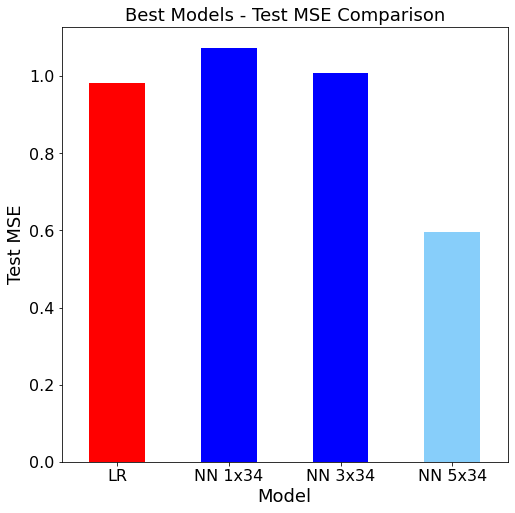

In [28]:
test_final = pd.DataFrame(data={"Model":["LR", "NN 1x34", "NN 3x34", "NN 5x34"],
                               "Test MSE":[0.983, 1.07405, 1.008034, 0.596636]})
ax = test_final.plot.bar(x='Model', y='Test MSE', rot=0,
                         fontsize = 16, legend=False, figsize = (8,8),
                         color = ["r","b","b","lightskyblue"]);
ax.set_xlabel("Model", fontsize=18);
ax.set_ylabel("Test MSE", fontsize=18);
ax.set_title("Best Models - Test MSE Comparison", fontsize = 18);

**Here we can see an overall comparison of our linear regression model (red) and our top three neural networks (blue and cyan) by testing MSE. Interestingly, while each neural network had a better validation MSE against the linear regression, all but one of the neural networks had a worse testing MSE. Fortunately, our best neural network model (cyan) had a much better testing MSE than our linear regression model.**